# Transfer + no augment

In [2]:
import os 
import pandas
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf 


In [3]:
data_dir = '/kaggle/input/plant-doc-dataset/PlantDoc-Dataset'

train_dir = os.path.join(data_dir,'train')

test_dir = os.path.join(data_dir,'test')



In [4]:
batch_size = 32
img_size = (256, 256) 
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"  
)

val_generator = train_datagen.flow_from_directory(
    train_dir,  
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

num_classes = len(train_generator.class_indices)


Found 1866 images belonging to 27 classes.
Found 450 images belonging to 27 classes.
Found 236 images belonging to 27 classes.


## Resnet

In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load ResNet50 (pre-trained on ImageNet, exclude top layers)
TFbase_model_resnet50 = ResNet50(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

TFbase_model_resnet50.trainable = False

# Build the model
TFmodel_resnet50 = Sequential([
    TFbase_model_resnet50,
    GlobalAveragePooling2D(),
    BatchNormalization(),  # ✅ Helps stabilize training
    Dense(512, activation="relu"),
    Dropout(0.4),  # ✅ Increase dropout to reduce overfitting
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

# Compile the model with a lower learning rate
TFmodel_resnet50.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=["accuracy"])

# Show model summary
TFmodel_resnet50.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 27)                  │           6,939 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,783,259 (94.54 MB)

 Trainable params: 1,191,451 (4.55 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [6]:
epochs = 20

with tf.device('/GPU:0'):  # Force training on GPU
    TFhistory_resnet50 = TFmodel_resnet50.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
    )


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


59/59 ━━━━━━━━━━━━━━━━━━━━ 70s 858ms/step - accuracy: 0.0663 - loss: 3.3712 - val_accuracy: 0.0822 - val_loss: 3.2805
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 34s 521ms/step - accuracy: 0.1037 - loss: 3.1884 - val_accuracy: 0.0778 - val_loss: 3.2507
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 509ms/step - accuracy: 0.1272 - loss: 3.0837 - val_accuracy: 0.1022 - val_loss: 3.2275
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 502ms/step - accuracy: 0.1303 - loss: 3.0191 - val_accuracy: 0.1067 - val_loss: 3.1980
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 504ms/step - accuracy: 0.1632 - loss: 2.9292 - val_accuracy: 0.1511 - val_loss: 3.1534
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 34s 493ms/step - accuracy: 0.1584 - loss: 2.8944 - val_accuracy: 0.1622 - val_loss: 3.0999
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 507ms/step - accuracy: 0.1772 - loss: 2.8279 - val_accuracy: 0.1622 - val_loss: 3.0609
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 511ms/step - accuracy: 0.1895 - loss: 2.7546 - val_accuracy: 0.166

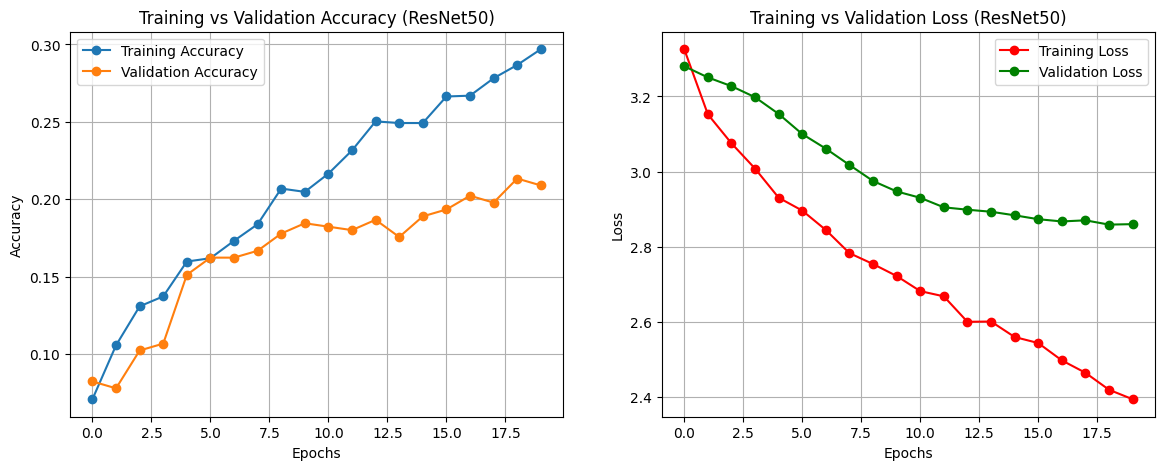

In [7]:
import matplotlib.pyplot as plt

# Tạo figure và axes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Vẽ Accuracy
axes[0].plot(TFhistory_resnet50.history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(TFhistory_resnet50.history['val_accuracy'], label='Validation Accuracy', marker='o')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Training vs Validation Accuracy (ResNet50)")
axes[0].legend()
axes[0].grid()

# Vẽ Loss
axes[1].plot(TFhistory_resnet50.history['loss'], label='Training Loss', marker='o', color='r')
axes[1].plot(TFhistory_resnet50.history['val_loss'], label='Validation Loss', marker='o', color='g')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Training vs Validation Loss (ResNet50)")
axes[1].legend()
axes[1].grid()

# Lưu hình ảnh với tên 'transfer_resnet50.png'

plt.show()


In [8]:
test_loss, test_acc = TFmodel_resnet50.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

print(f"Test Loss: {test_loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 966ms/step - accuracy: 0.1581 - loss: 3.1305
Test Accuracy: 17.80%
Test Loss: 3.0711


## MobileNetV2

In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 (pre-trained on ImageNet, exclude top layers)
TFbase_model_mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

TFbase_model_mobilenet.trainable = False

# Build the model
TFmodel_mobilenet = Sequential([
    TFbase_model_mobilenet,
    GlobalAveragePooling2D(),
    BatchNormalization(),  # ✅ Helps stabilize training
    Dense(512, activation="relu"),
    Dropout(0.4),  # ✅ Increase dropout to reduce overfitting
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

# Compile the model with a lower learning rate
TFmodel_mobilenet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=["accuracy"])

# Show model summary
TFmodel_mobilenet.summary()

<ipython-input-9-358cf94aa280>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  TFbase_model_mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_shape=(256, 256, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 27)                  │           6,939 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,057,243 (11.66 MB)

 Trainable params: 796,699 (3.04 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [10]:
epochs = 20
with tf.device('/GPU:0'):
      TFhistory_mobilenet = TFmodel_mobilenet.fit(
      train_generator,
      validation_data=val_generator,
      epochs=epochs
      )

Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 663ms/step - accuracy: 0.0722 - loss: 3.8076 - val_accuracy: 0.2133 - val_loss: 2.9465
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 515ms/step - accuracy: 0.1866 - loss: 3.0094 - val_accuracy: 0.3111 - val_loss: 2.6167
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 499ms/step - accuracy: 0.2838 - loss: 2.5844 - val_accuracy: 0.3622 - val_loss: 2.3616
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 519ms/step - accuracy: 0.3232 - loss: 2.3280 - val_accuracy: 0.4044 - val_loss: 2.1637
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 32s 506ms/step - accuracy: 0.4101 - loss: 2.0472 - val_accuracy: 0.4378 - val_loss: 2.0100
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 507ms/step - accuracy: 0.4142 - loss: 1.9472 - val_accuracy: 0.4644 - val_loss: 1.8982
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 32s 491ms/step - accuracy: 0.4537 - loss: 1.8207 - val_accuracy: 0.4622 - val_loss: 1.8071
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 32s 473ms/step - accuracy: 0.5188 - loss: 1.6114 - val_accu

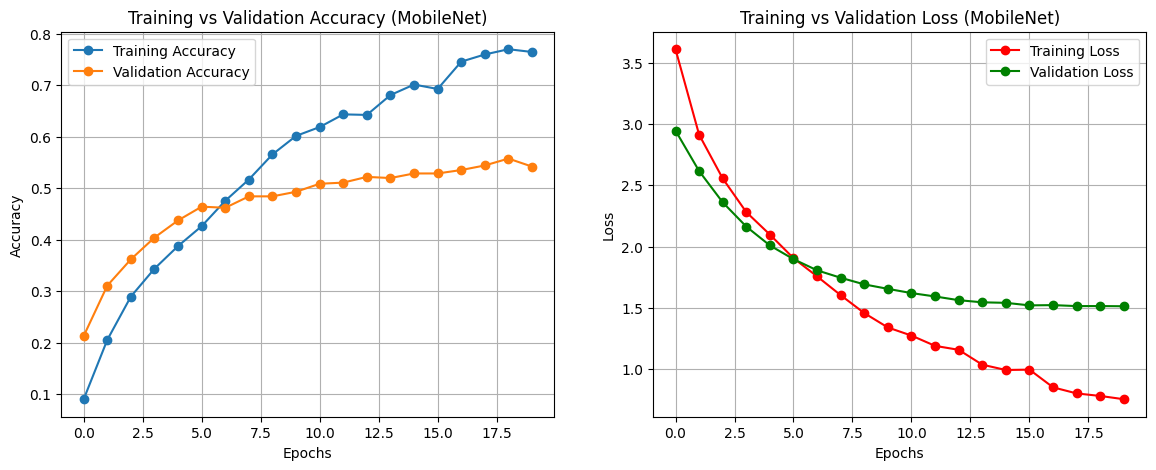

In [11]:
import matplotlib.pyplot as plt

# Tạo figure và axes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Vẽ Accuracy
axes[0].plot(TFhistory_mobilenet.history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(TFhistory_mobilenet.history['val_accuracy'], label='Validation Accuracy', marker='o')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Training vs Validation Accuracy (MobileNet)")
axes[0].legend()
axes[0].grid()

# Vẽ Loss
axes[1].plot(TFhistory_mobilenet.history['loss'], label='Training Loss', marker='o', color='r')
axes[1].plot(TFhistory_mobilenet.history['val_loss'], label='Validation Loss', marker='o', color='g')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Training vs Validation Loss (MobileNet)")
axes[1].legend()
axes[1].grid()

# Lưu hình ảnh với tên 'transfer_mobilenet.png'

plt.show()


In [12]:
test_loss, test_acc = TFmodel_mobilenet.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

print(f"Test Loss: {test_loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 888ms/step - accuracy: 0.4688 - loss: 1.7562
Test Accuracy: 50.00%
Test Loss: 1.7221


## InceptionV3

In [13]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load InceptionV3 (pre-trained on ImageNet, exclude top layers)
TFbase_model_inception = InceptionV3(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

TFbase_model_inception.trainable = False

# Build the model
TFmodel_inception = Sequential([
    TFbase_model_inception,
    GlobalAveragePooling2D(),
    BatchNormalization(),  # ✅ Helps stabilize training
    Dense(512, activation="relu"),
    Dropout(0.4),  # ✅ Increase dropout to reduce overfitting
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

# Compile the model with a lower learning rate
TFmodel_inception.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=["accuracy"])

# Show model summary
TFmodel_inception.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 6, 6, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_96               │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 27)                  │           6,939 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,998,331 (87.73 MB)

 Trainable params: 1,191,451 (4.55 MB)

 Non-trainable params: 21,806,880 (83.19 MB)

In [14]:
epochs = 20
with tf.device('/GPU:0'): 
    TFhistory_inception = TFmodel_inception.fit(  
        train_generator,
        validation_data=val_generator,
        epochs=epochs
    )


Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 73s 871ms/step - accuracy: 0.0565 - loss: 4.0250 - val_accuracy: 0.2156 - val_loss: 2.9986
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 515ms/step - accuracy: 0.1834 - loss: 2.9945 - val_accuracy: 0.3222 - val_loss: 2.6974
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 32s 495ms/step - accuracy: 0.2744 - loss: 2.5264 - val_accuracy: 0.3778 - val_loss: 2.4642
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 32s 501ms/step - accuracy: 0.3532 - loss: 2.2379 - val_accuracy: 0.4089 - val_loss: 2.2741
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 505ms/step - accuracy: 0.4067 - loss: 2.0120 - val_accuracy: 0.4244 - val_loss: 2.1276
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 32s 493ms/step - accuracy: 0.4702 - loss: 1.7756 - val_accuracy: 0.4178 - val_loss: 2.0270
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 32s 505ms/step - accuracy: 0.5016 - loss: 1.6751 - val_accuracy: 0.4378 - val_loss: 1.9458
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 486ms/step - accuracy: 0.5235 - loss: 1.5361 - val_accu

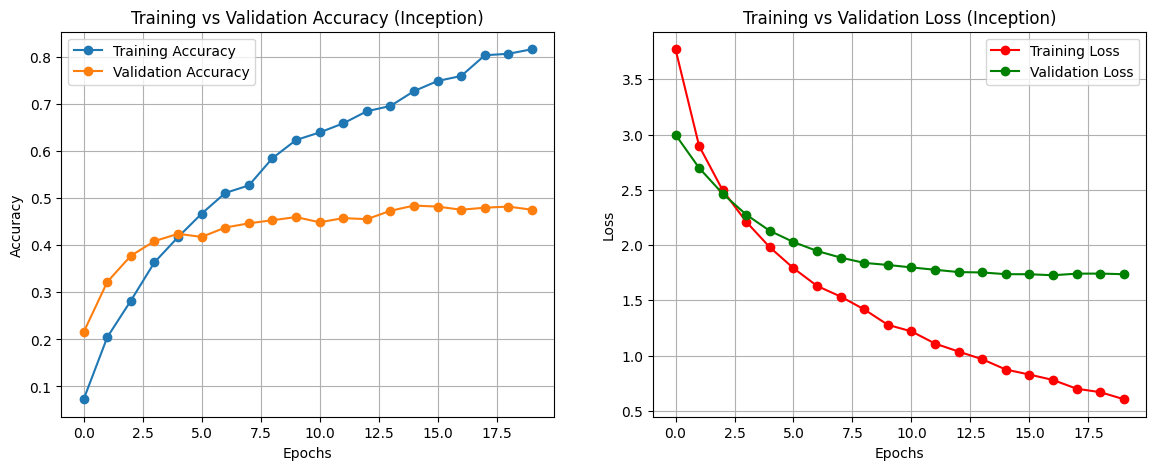

In [15]:
import matplotlib.pyplot as plt

# Tạo figure và axes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Vẽ Accuracy
axes[0].plot(TFhistory_inception.history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(TFhistory_inception.history['val_accuracy'], label='Validation Accuracy', marker='o')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Training vs Validation Accuracy (Inception)")
axes[0].legend()
axes[0].grid()

# Vẽ Loss
axes[1].plot(TFhistory_inception.history['loss'], label='Training Loss', marker='o', color='r')
axes[1].plot(TFhistory_inception.history['val_loss'], label='Validation Loss', marker='o', color='g')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Training vs Validation Loss (Inception)")
axes[1].legend()
axes[1].grid()

# Lưu hình ảnh vào thư mục Kaggle

plt.show()


In [16]:
 test_loss, test_acc = TFmodel_inception.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

print(f"Test Loss: {test_loss:.4f}")



8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4316 - loss: 1.9632 
Test Accuracy: 44.49%
Test Loss: 1.9221


## EfficientNetV2

In [17]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load EfficientNetV2 (pre-trained on ImageNet, exclude top layers)
TFbase_model_efficientnet = EfficientNetV2B0(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

TFbase_model_efficientnet.trainable = False

# Build the model
TFmodel_efficientnet = Sequential([
    TFbase_model_efficientnet,
    GlobalAveragePooling2D(),
    BatchNormalization(),  # ✅ Helps stabilize training
    Dense(512, activation="relu"),
    Dropout(0.4),  # ✅ Increase dropout to reduce overfitting
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

# Compile the model with a lower learning rate
TFmodel_efficientnet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=["accuracy"])

# Show model summary
TFmodel_efficientnet.summary()




24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)       │ (None, 8, 8, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_97               │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 27)                  │           6,939 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,718,571 (25.63 MB)

 Trainable params: 796,699 (3.04 MB)

 Non-trainable params: 5,921,872 (22.59 MB)

In [18]:
epochs = 20
with tf.device('/GPU:0'):
      TFhistory_efficientnet = TFmodel_efficientnet.fit(
      train_generator,
      validation_data=val_generator,
      epochs=epochs 
      )

Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 80s 898ms/step - accuracy: 0.0285 - loss: 3.6137 - val_accuracy: 0.0600 - val_loss: 3.2953
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 34s 519ms/step - accuracy: 0.0399 - loss: 3.3996 - val_accuracy: 0.0800 - val_loss: 3.2863
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 497ms/step - accuracy: 0.0577 - loss: 3.3476 - val_accuracy: 0.0800 - val_loss: 3.2885
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 524ms/step - accuracy: 0.0643 - loss: 3.3531 - val_accuracy: 0.0800 - val_loss: 3.2871
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 496ms/step - accuracy: 0.0529 - loss: 3.3406 - val_accuracy: 0.0800 - val_loss: 3.2863
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 504ms/step - accuracy: 0.0505 - loss: 3.3375 - val_accuracy: 0.0800 - val_loss: 3.2848
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 32s 502ms/step - accuracy: 0.0509 - loss: 3.3265 - val_accuracy: 0.0800 - val_loss: 3.2826
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 509ms/step - accuracy: 0.0575 - loss: 3.3080 - val_accu

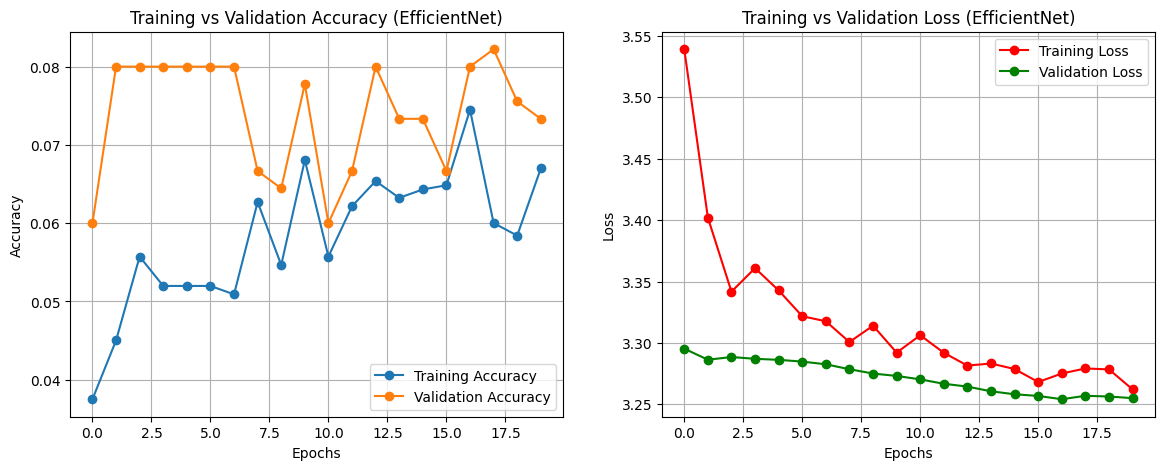

In [19]:
import matplotlib.pyplot as plt

# Tạo figure và axes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Vẽ Accuracy
axes[0].plot(TFhistory_efficientnet.history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(TFhistory_efficientnet.history['val_accuracy'], label='Validation Accuracy', marker='o')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Training vs Validation Accuracy (EfficientNet)")
axes[0].legend()
axes[0].grid()

# Vẽ Loss
axes[1].plot(TFhistory_efficientnet.history['loss'], label='Training Loss', marker='o', color='r')
axes[1].plot(TFhistory_efficientnet.history['val_loss'], label='Validation Loss', marker='o', color='g')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Training vs Validation Loss (EfficientNet)")
axes[1].legend()
axes[1].grid()

# Lưu hình ảnh vào thư mục Kaggle

plt.show()


In [20]:
test_loss, test_acc = TFmodel_efficientnet.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

print(f"Test Loss: {test_loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.0398 - loss: 3.2891  
Test Accuracy: 5.08%
Test Loss: 3.2801


# Fine-Tune + augmentation

In [21]:
data_dir = '/kaggle/input/plant-doc-dataset/PlantDoc-Dataset'

train_dir = os.path.join(data_dir,'train')

test_dir = os.path.join(data_dir,'test')

In [22]:
batch_size = 32
target_size = (256, 256)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

val_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)

# Load dataset with augmentation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset='training'
)

val_generator = val_datagen.flow_from_directory(  
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation'
)


test_datagen = ImageDataGenerator(rescale=1./255)  
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False  # Do NOT shuffle for test evaluation
)


# Lấy số lớp
num_classes = train_generator.num_classes  
print(f"Number of classes: {num_classes}")

# Lấy danh sách tên lớp
class_names = list(train_generator.class_indices.keys())
print(f"Class names: {class_names}")


Found 2316 images belonging to 27 classes.
Found 450 images belonging to 27 classes.
Found 236 images belonging to 27 classes.
Number of classes: 27
Class names: ['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'grape leaf', 'grape leaf black rot']


## Resnet

In [24]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load ResNet50 (pre-trained on ImageNet, exclude top layers)
FTbase_model_resnet50 = ResNet50(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

# Unfreeze top layers for fine-tuning
for layer in FTbase_model_resnet50.layers[-30:]:  # Train last 20 layers
    layer.trainable = True

# Build the model
FTmodel_resnet50 = Sequential([
    FTbase_model_resnet50,
    GlobalAveragePooling2D(),
    BatchNormalization(),  # ✅ Helps stabilize training
    Dense(512, activation="relu"),
    Dropout(0.4),  # ✅ Increase dropout to reduce overfitting
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

# Compile the model with a lower learning rate
FTmodel_resnet50.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=["accuracy"])

# Show model summary
FTmodel_resnet50.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_99               │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 27)                  │           6,939 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,783,259 (94.54 MB)

 Trainable params: 24,726,043 (94.32 MB)

 Non-trainable params: 57,216 (223.50 KB)

In [25]:
epochs = 20
with tf.device('/GPU:0'):

  FThistory_resnet50 = FTmodel_resnet50.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
  )

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


73/73 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.0978 - loss: 3.6152 - val_accuracy: 0.0400 - val_loss: 3.5891
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 69s 859ms/step - accuracy: 0.3404 - loss: 2.2920 - val_accuracy: 0.0800 - val_loss: 3.3069
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 68s 848ms/step - accuracy: 0.4799 - loss: 1.7144 - val_accuracy: 0.0467 - val_loss: 3.4645
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 69s 869ms/step - accuracy: 0.5695 - loss: 1.4218 - val_accuracy: 0.0800 - val_loss: 3.5117
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 70s 887ms/step - accuracy: 0.6172 - loss: 1.2322 - val_accuracy: 0.0578 - val_loss: 3.4469
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 70s 867ms/step - accuracy: 0.6999 - loss: 0.9899 - val_accuracy: 0.0778 - val_loss: 3.3861
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 69s 857ms/step - accuracy: 0.7358 - loss: 0.8531 - val_accuracy: 0.1311 - val_loss: 3.6261
Epoch 8/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 68s 849ms/step - accuracy: 0.7564 - loss: 0.7966 - val_accuracy: 0.1933 

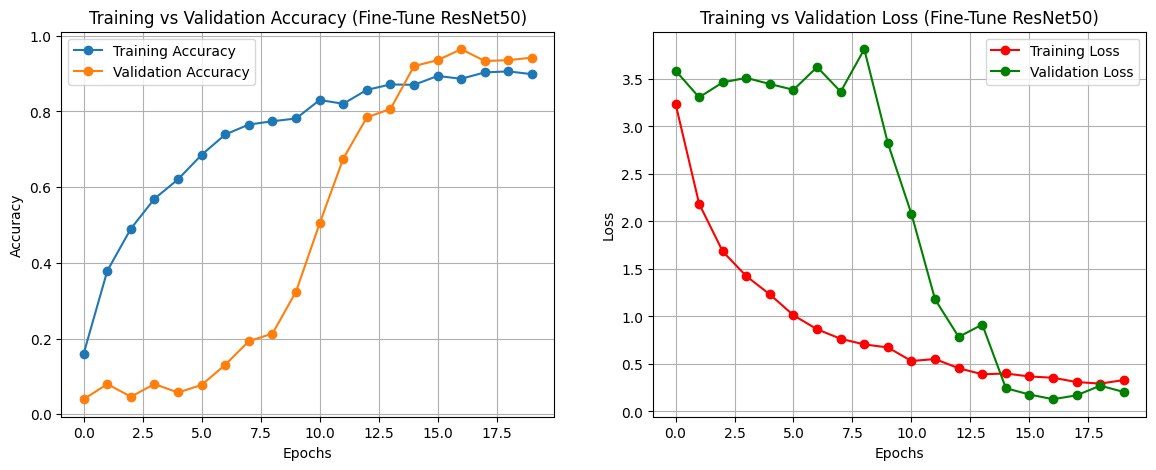

In [26]:
import matplotlib.pyplot as plt

# Tạo figure và axes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Vẽ Accuracy
axes[0].plot(FThistory_resnet50.history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(FThistory_resnet50.history['val_accuracy'], label='Validation Accuracy', marker='o')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Training vs Validation Accuracy (Fine-Tune ResNet50)")
axes[0].legend()
axes[0].grid()

# Vẽ Loss
axes[1].plot(FThistory_resnet50.history['loss'], label='Training Loss', marker='o', color='r')
axes[1].plot(FThistory_resnet50.history['val_loss'], label='Validation Loss', marker='o', color='g')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Training vs Validation Loss (Fine-Tune ResNet50)")
axes[1].legend()
axes[1].grid()

# Lưu hình ảnh vào thư mục Kaggle

plt.show()


In [28]:
# Evaluate on test data
test_loss, test_accuracy = FTmodel_resnet50.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 543ms/step - accuracy: 0.5187 - loss: 2.2882
Test Loss: 2.1828
Test Accuracy: 54.24%


## MobileNetV2

In [29]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 (pre-trained on ImageNet, exclude top layers)
FTbase_model_mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

# Unfreeze top layers for fine-tuning
for layer in FTbase_model_mobilenet.layers[-30:]:  
    layer.trainable = True

# Build the model
FTmodel_mobilenet = Sequential([
    FTbase_model_mobilenet,
    GlobalAveragePooling2D(),
    BatchNormalization(),  
    Dense(512, activation="relu"),
    Dropout(0.4),  
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

# Compile the model with a lower learning rate
FTmodel_mobilenet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=["accuracy"])

# Show model summary
FTmodel_mobilenet.summary()




<ipython-input-29-78e22d88597d>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  FTbase_model_mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_shape=(256, 256, 3))


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_100              │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 27)                  │           6,939 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,057,243 (11.66 MB)

 Trainable params: 3,020,571 (11.52 MB)

 Non-trainable params: 36,672 (143.25 KB)

In [30]:
epochs = 20
with tf.device('/GPU:0'):  
    FThistory_mobilenet = FTmodel_mobilenet.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        
    )


Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.0767 - loss: 3.7421 - val_accuracy: 0.1911 - val_loss: 2.8622
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 65s 800ms/step - accuracy: 0.2609 - loss: 2.6306 - val_accuracy: 0.3200 - val_loss: 2.3550
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 65s 824ms/step - accuracy: 0.3707 - loss: 2.1747 - val_accuracy: 0.4067 - val_loss: 2.0096
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 64s 789ms/step - accuracy: 0.4506 - loss: 1.8431 - val_accuracy: 0.4778 - val_loss: 1.6811
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 64s 813ms/step - accuracy: 0.5206 - loss: 1.5788 - val_accuracy: 0.5444 - val_loss: 1.4723
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 65s 824ms/step - accuracy: 0.5734 - loss: 1.4028 - val_accuracy: 0.5978 - val_loss: 1.2830
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 65s 804ms/step - accuracy: 0.6081 - loss: 1.2679 - val_accuracy: 0.6489 - val_loss: 1.0824
Epoch 8/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 66s 820ms/step - accuracy: 0.6412 - loss: 1.1457 - val_accura

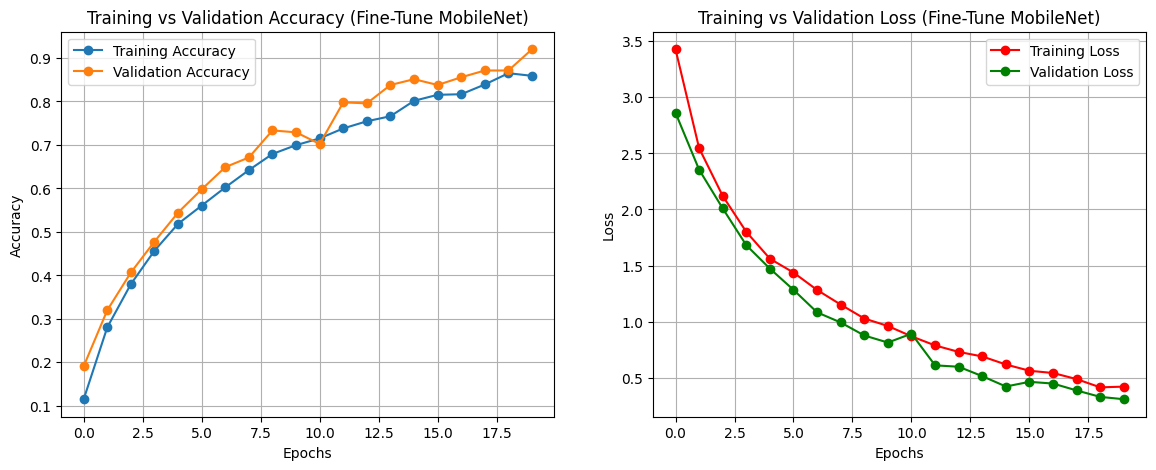

In [31]:
import matplotlib.pyplot as plt

# Tạo figure và axes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Vẽ Accuracy
axes[0].plot(FThistory_mobilenet.history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(FThistory_mobilenet.history['val_accuracy'], label='Validation Accuracy', marker='o')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Training vs Validation Accuracy (Fine-Tune MobileNet)")
axes[0].legend()
axes[0].grid()

# Vẽ Loss
axes[1].plot(FThistory_mobilenet.history['loss'], label='Training Loss', marker='o', color='r')
axes[1].plot(FThistory_mobilenet.history['val_loss'], label='Validation Loss', marker='o', color='g')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Training vs Validation Loss (Fine-Tune MobileNet)")
axes[1].legend()
axes[1].grid()


plt.show()


In [32]:
# Evaluate on test data
test_loss, test_accuracy = FTmodel_mobilenet.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 597ms/step - accuracy: 0.5290 - loss: 1.6676
Test Loss: 1.6502
Test Accuracy: 51.27%


## InceptionV3

In [33]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load InceptionV3 (pre-trained on ImageNet, exclude top layers)
FTbase_model_inception = InceptionV3(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

# Unfreeze top layers for fine-tuning
for layer in FTbase_model_inception.layers[-30:]:  # ✅ Train last 30 layers
    layer.trainable = True

# Build the model
FTmodel_inception = Sequential([
    FTbase_model_inception,
    GlobalAveragePooling2D(),
    BatchNormalization(),  # ✅ Helps stabilize training
    Dense(512, activation="relu"),
    Dropout(0.4),  # ✅ Increase dropout to reduce overfitting
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

# Compile the model with a lower learning rate
FTmodel_inception.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=["accuracy"])

# Show model summary
FTmodel_inception.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 6, 6, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_195              │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 27)                  │           6,939 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,998,331 (87.73 MB)

 Trainable params: 22,959,803 (87.58 MB)

 Non-trainable params: 38,528 (150.50 KB)

In [34]:
epochs = 20

FThistory_inception = FTmodel_inception.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,

)


Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.0823 - loss: 3.9200 - val_accuracy: 0.3244 - val_loss: 2.6898
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 67s 840ms/step - accuracy: 0.3193 - loss: 2.4638 - val_accuracy: 0.4956 - val_loss: 1.9553
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 67s 843ms/step - accuracy: 0.4149 - loss: 1.9784 - val_accuracy: 0.6022 - val_loss: 1.4439
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 67s 844ms/step - accuracy: 0.4806 - loss: 1.6988 - val_accuracy: 0.6844 - val_loss: 1.0484
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 67s 839ms/step - accuracy: 0.5741 - loss: 1.3941 - val_accuracy: 0.7400 - val_loss: 0.8139
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 67s 838ms/step - accuracy: 0.6198 - loss: 1.2205 - val_accuracy: 0.8089 - val_loss: 0.6026
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 67s 830ms/step - accuracy: 0.6638 - loss: 1.0346 - val_accuracy: 0.8311 - val_loss: 0.5320
Epoch 8/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 67s 838ms/step - accuracy: 0.7206 - loss: 0.9258 - val_accura

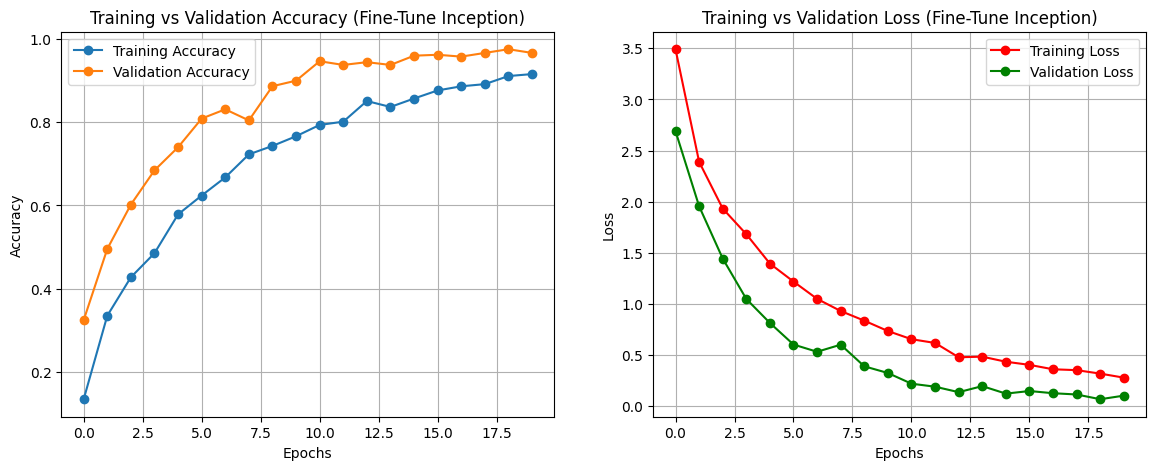

In [35]:
import matplotlib.pyplot as plt

# Tạo figure và axes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Vẽ Accuracy
axes[0].plot(FThistory_inception.history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(FThistory_inception.history['val_accuracy'], label='Validation Accuracy', marker='o')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Training vs Validation Accuracy (Fine-Tune Inception)")
axes[0].legend()
axes[0].grid()

# Vẽ Loss
axes[1].plot(FThistory_inception.history['loss'], label='Training Loss', marker='o', color='r')
axes[1].plot(FThistory_inception.history['val_loss'], label='Validation Loss', marker='o', color='g')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Training vs Validation Loss (Fine-Tune Inception)")
axes[1].legend()
axes[1].grid()


plt.show()


In [36]:
# Evaluate on test data
test_loss, test_accuracy = FTmodel_inception.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 929ms/step - accuracy: 0.5528 - loss: 2.1054
Test Loss: 2.2628
Test Accuracy: 52.54%


## EfficientV2

In [37]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load EfficientNetV2 (pre-trained on ImageNet, exclude top layers)
FTbase_model_efficientnet = EfficientNetV2B0(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

# Unfreeze top layers for fine-tuning
for layer in FTbase_model_efficientnet.layers[-30:]:  
    layer.trainable = True

# Build the model
FTmodel_efficientnet = Sequential([
    FTbase_model_efficientnet,
    GlobalAveragePooling2D(),
    BatchNormalization(),  # ✅ Helps stabilize training
    Dense(512, activation="relu"),
    Dropout(0.4),  # ✅ Increase dropout to reduce overfitting
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

# Compile the model with a lower learning rate
FTmodel_efficientnet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=["accuracy"])

# Show model summary
FTmodel_efficientnet.summary()




Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)       │ (None, 8, 8, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_196              │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 27)                  │           6,939 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,718,571 (25.63 MB)

 Trainable params: 6,655,403 (25.39 MB)

 Non-trainable params: 63,168 (246.75 KB)

In [38]:
epochs = 20

FThistory_efficientnet = FTmodel_efficientnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.0586 - loss: 3.8876 - val_accuracy: 0.1422 - val_loss: 3.1691
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 65s 829ms/step - accuracy: 0.1403 - loss: 3.1998 - val_accuracy: 0.3178 - val_loss: 2.8475
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 65s 812ms/step - accuracy: 0.2208 - loss: 2.8072 - val_accuracy: 0.3467 - val_loss: 2.6074
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 65s 810ms/step - accuracy: 0.2920 - loss: 2.4865 - val_accuracy: 0.3333 - val_loss: 2.3834
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 65s 817ms/step - accuracy: 0.3496 - loss: 2.2597 - val_accuracy: 0.4378 - val_loss: 2.1421
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 66s 812ms/step - accuracy: 0.3991 - loss: 2.0293 - val_accuracy: 0.3733 - val_loss: 2.1750
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 65s 816ms/step - accuracy: 0.4429 - loss: 1.8911 - val_accuracy: 0.6022 - val_loss: 1.3336
Epoch 8/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 66s 818ms/step - accuracy: 0.4517 - loss: 1.7854 - val_accura

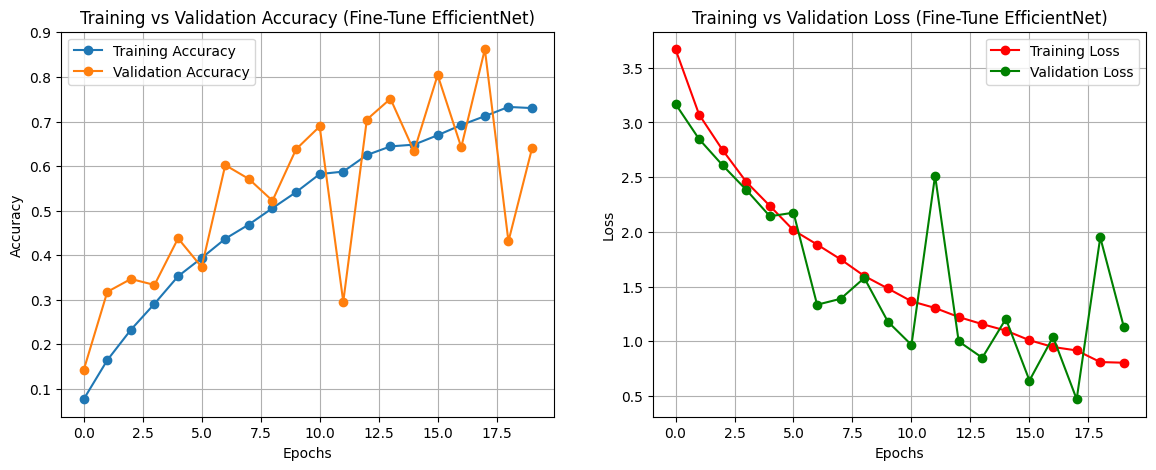

In [39]:
import matplotlib.pyplot as plt

# Tạo figure và axes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Vẽ Accuracy
axes[0].plot(FThistory_efficientnet.history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(FThistory_efficientnet.history['val_accuracy'], label='Validation Accuracy', marker='o')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Training vs Validation Accuracy (Fine-Tune EfficientNet)")
axes[0].legend()
axes[0].grid()

# Vẽ Loss
axes[1].plot(FThistory_efficientnet.history['loss'], label='Training Loss', marker='o', color='r')
axes[1].plot(FThistory_efficientnet.history['val_loss'], label='Validation Loss', marker='o', color='g')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Training vs Validation Loss (Fine-Tune EfficientNet)")
axes[1].legend()
axes[1].grid()

# Lưu hình ảnh vào thư mục Kaggle
plt.savefig("/kaggle/working/fine_tune_efficientnet.png", dpi=300)
plt.show()


In [40]:
# Evaluate on test data
test_loss, test_accuracy = FTmodel_efficientnet.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 816ms/step - accuracy: 0.4927 - loss: 1.8522
Test Loss: 1.7838
Test Accuracy: 50.00%
